## Load Libraries

In [2]:
#coding:utf-8
import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 12, 4
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

ImportError: No module named xgboost

In [2]:
# Customizng plots with style sheets
plt.style.use('ggplot')

## Read train data

In [1]:
basedir = "../data/"
action_train = pd.read_csv(basedir + "trainingset/action_train.csv")
orderFuture_train = pd.read_csv(basedir + "trainingset/orderFuture_train.csv")
orderHistory_train = pd.read_csv(basedir + "trainingset/orderHistory_train.csv")
userComment_train = pd.read_csv(basedir + "trainingset/userComment_train.csv")
userProfile_train = pd.read_csv(basedir + "trainingset/userProfile_train.csv")
# origin_train_data = pd.read_csv(basedir + "origin_train_data.csv")
print action_train.shape
print pd.to_datetime(action_train['actionTime'].min(), unit='s')
print pd.to_datetime(action_train['actionTime'].max(), unit='s')

NameError: name 'pd' is not defined

## Read Test Data

In [4]:
action_test = pd.read_csv(basedir + "test/action_test.csv")
orderFuture_test = pd.read_csv(basedir + "test/orderFuture_test.csv")
orderHistory_test = pd.read_csv(basedir + "test/orderHistory_test.csv")
userComment_test = pd.read_csv(basedir + "test/userComment_test.csv")
userProfile_test = pd.read_csv(basedir + "test/userProfile_test.csv")
print action_test.shape
print pd.to_datetime(action_test['actionTime'].min(), unit='s')
print pd.to_datetime(action_test['actionTime'].max(), unit='s')

(331204, 3)
2016-09-14 16:45:04
2017-09-10 23:50:38


## Check missing

In [25]:
print userProfile_train.shape
print userProfile_train.isnull().sum()
print userProfile_test.isnull().sum()
print orderFuture_train.shape
# print userProfile_train.province.mode()

(40307, 4)
userid          0
gender      24547
province     3895
age         35565
dtype: int64
userid         0
gender      6067
province    1004
age         8857
dtype: int64
(40307, 2)


Text(0.5,1,u'$Province$')

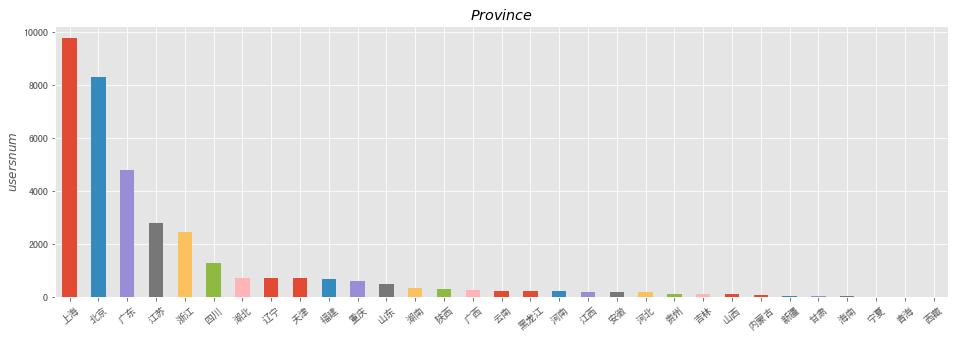

In [26]:
userProfile_train['province'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.xticks(rotation=40)
plt.ylabel("$users num$")
plt.title('$Province$')

Text(0.5,1,u'$Gender$')

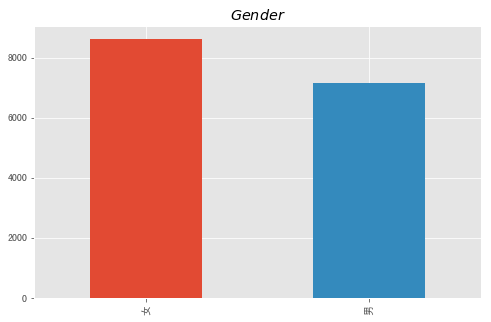

In [22]:
userProfile_train['gender'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$Gender$')

Text(0.5,1,u'$Age$')

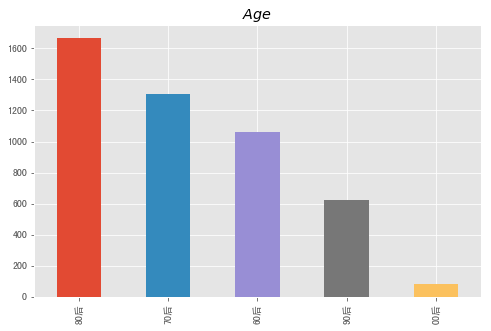

In [21]:
userProfile_train['age'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$Age$')

Text(0.5,1,u'$actionType$')

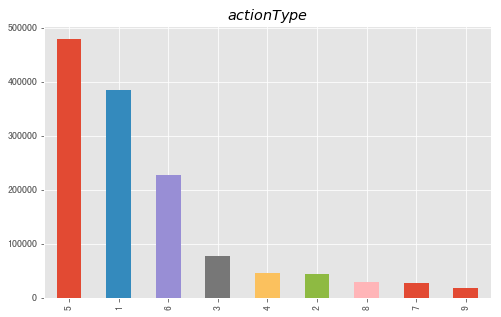

In [28]:
action_train['actionType'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$actionType$')

Text(0.5,1,u'$orderType$')

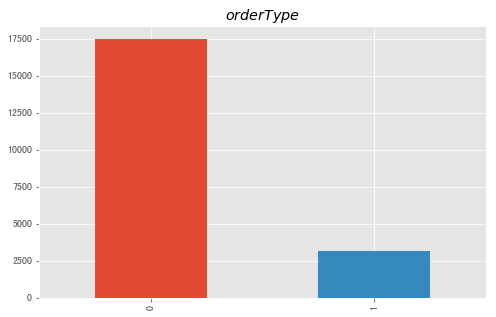

In [29]:
orderHistory_train['orderType'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$orderType$')

Text(0.5,1,u'$country$')

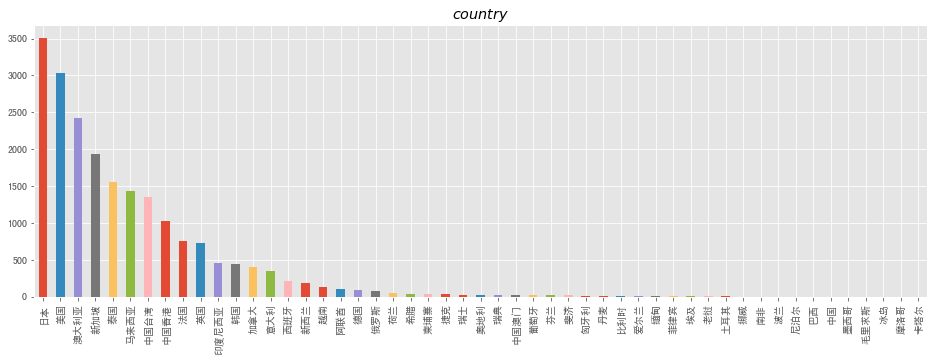

In [31]:
orderHistory_train['country'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.title('$country$')

Text(0.5,1,u'$continent$')

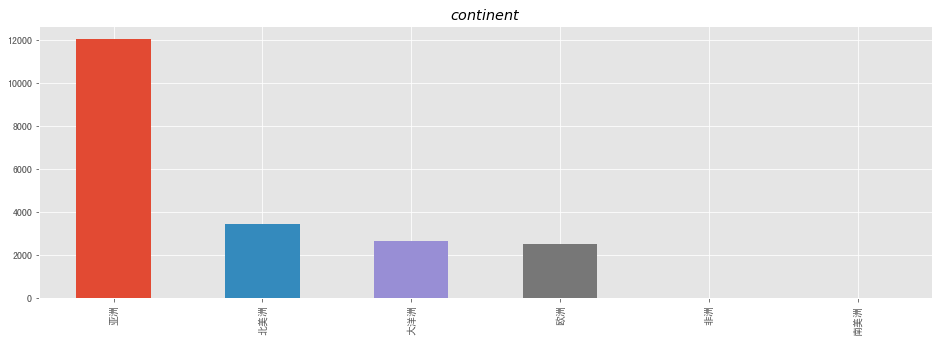

In [32]:
orderHistory_train['continent'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.title('$continent$')

Text(0.5,1,u'$rating$')

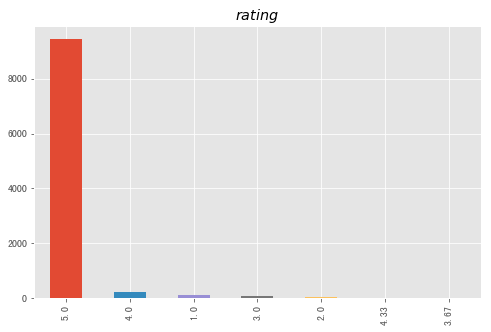

In [34]:
userComment_train['rating'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$rating$')

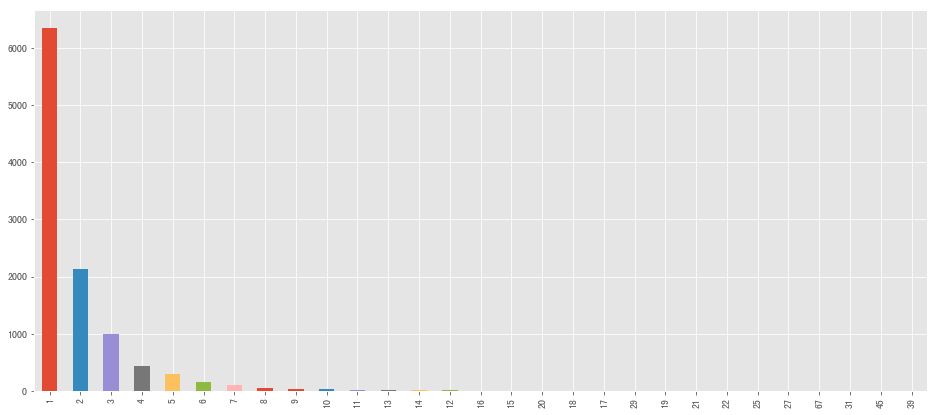

In [24]:
orderHistory_train.groupby(['userid']).size().value_counts().plot(kind='bar', figsize=(16, 7))
# orderHistory_train.groupby(['userid']).size().plot(kind='bar', figsize=(10, 7))

根据上图的结果，绝大用户历史订单数量在1个或2个，结合后面的特征重要度，可见统计每个用户每个月的订单数量是不合理的。

## Look at categories of all object variables:

In [36]:
var = ['gender', 'province', 'age']
for v in var:
    print '\nFrequency count for variable %s'%v
    print userProfile_train[v].value_counts()
    print userProfile_test[v].value_counts()


Frequency count for variable gender
女    8620
男    7140
Name: gender, dtype: int64
女    2198
男    1811
Name: gender, dtype: int64

Frequency count for variable province
上海     9760
北京     8301
广东     4784
江苏     2813
浙江     2447
四川     1310
湖北      741
辽宁      725
天津      722
福建      693
重庆      617
山东      510
湖南      334
陕西      323
广西      288
云南      242
黑龙江     234
河南      228
江西      214
安徽      206
河北      203
贵州      143
吉林      143
山西      108
内蒙古      79
新疆       69
甘肃       69
海南       61
宁夏       30
青海       11
西藏        4
Name: province, dtype: int64
上海     2383
北京     2024
广东     1198
江苏      733
浙江      635
四川      342
湖北      190
辽宁      178
天津      163
福建      161
重庆      142
山东      139
湖南       94
广西       86
陕西       84
云南       66
江西       63
安徽       60
河南       55
黑龙江      55
河北       50
吉林       32
山西       30
贵州       25
海南       22
新疆       21
内蒙古      17
甘肃       13
宁夏        5
青海        4
西藏        2
Name: province, dtype: int64

Frequency count for variabl

In [37]:
var = ['orderType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print orderFuture_train[v].value_counts()

var = ['actionType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print action_train[v].value_counts()


Frequency count for variable orderType
0    33682
1     6625
Name: orderType, dtype: int64

Frequency count for variable actionType
5    479227
1    384875
6    227223
3     78034
4     45386
2     44862
8     28779
7     28083
9     18387
Name: actionType, dtype: int64


In [38]:
var = ['rating']
for v in var:
    print '\nFrequency count for variable %s'%v
    print userComment_train[v].value_counts()


Frequency count for variable rating
5.00    9447
4.00     205
1.00      96
3.00      78
2.00      32
4.33       3
3.67       2
Name: rating, dtype: int64


## Merge user Order History and comment

In [25]:
continent_gdp = pd.read_csv(basedir + "continent.csv")

def createFeature(dataset):
    orderHistory = pd.read_csv(basedir + "orderHistory_" + dataset + ".csv")
    userComment = pd.read_csv(basedir + "userComment_" + dataset + ".csv")
#     userComment.loc[userComment.tags.isnull(), 'tags'] = 0
#     userComment.loc[userComment.tags.notnull(), 'tags'] = 1
#     userComment.loc[userComment.commentsKeyWords.isnull(), 'commentsKeyWords'] = 0
#     userComment.loc[userComment.commentsKeyWords.notnull(), 'commentsKeyWords'] = 1
    orderFuture = pd.read_csv(basedir + "orderFuture_" + dataset + ".csv")
    userOrderHistoryComment = pd.merge(orderHistory, userComment, on=["userid", "orderid"], how='left')
    userOrderHistoryComment = pd.merge(userOrderHistoryComment, continent_gdp, on=["continent",], how='left')
    print userOrderHistoryComment.head(1)
    userOrderHistoryComment.drop('commentsKeyWords', axis=1, inplace=True)
    userOrderHistoryComment.drop('orderid', axis=1, inplace=True)
    
    userOrderHistoryComment_group = userOrderHistoryComment.groupby('userid')

    orderDf = pd.DataFrame(orderFuture['userid'], columns = ['userid'])


    orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].count(), on='userid')
    orderDf.rename(columns={'orderType': 'order_num'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].mean(), on='userid')
    orderDf.rename(columns={'rating': 'rating_mean'}, inplace=True)
#     orderDf = orderDf.join(userOrderHistoryComment_group['rating'].max(), on='userid')
#     orderDf.rename(columns={'rating': 'rating_max'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].min(), on='userid')
    orderDf.rename(columns={'rating': 'rating_min'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].std(), on='userid')
    orderDf.rename(columns={'rating': 'rating_std'}, inplace=True)

    # Order Time
#     orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].mean(), on='userid')
#     orderDf.rename(columns={'orderTime': 'orderTime_mean'}, inplace=True)
#     orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].median(), on='userid')
#     orderDf.rename(columns={'orderTime': 'orderTime_median'}, inplace=True)
#     orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].min(), on='userid')
#     orderDf.rename(columns={'orderTime': 'orderTime_min'}, inplace=True)
#     orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].std(), on='userid')
#     orderDf.rename(columns={'orderTime': 'orderTime_std'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].sum(), on='userid')
    orderDf.rename(columns={'orderType': 'orderType_sum'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].mean(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_mean'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].max(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_max'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].min(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_min'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].std(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_std'}, inplace=True)

#     order_month = pd.read_csv(basedir + "order_month_" + dataset + ".csv")
#     orderDf = pd.merge(orderDf, order_month, on=["userid"], how='left')
    return orderDf


print createFeature("test").head(3)

         userid  orderid   orderTime  orderType city country continent  \
0  100000000371  1000029  1503443585          0   东京      日本        亚洲   

   rating tags commentsKeyWords  continent_gdp  
0     NaN  NaN              NaN          0.646  
         userid  order_num  rating_mean  rating_min  rating_std  \
0  100000000371        1.0          NaN         NaN         NaN   
1  100000001215        NaN          NaN         NaN         NaN   
2  100000001445        5.0          5.0         5.0         NaN   

   orderType_sum  continent_gdp_mean  continent_gdp_max  continent_gdp_min  \
0            0.0              0.6460              0.646              0.646   
1            NaN                 NaN                NaN                NaN   
2            0.0              1.4602              4.717              0.646   

   continent_gdp_std  
0                NaN  
1                NaN  
2           1.820607  


In [21]:
# print action_train[action_train.userid == 100000000013]['userid'].count()
action_train_group = action_train.groupby('userid')
user_action_dict = dict(list(action_train_group))
action9_order_result = []
count = 0
for userid, userid_action in user_action_dict.iteritems():
    actionTypeList = np.array(userid_action['actionType'])
    type9 = np.count_nonzero(actionTypeList == 9)
    orderNum = orderHistory_train[orderHistory_train.userid == userid]['userid'].count()
    action9_order_result.append([userid, type9, orderNum])
    count = count + 1
#     if count == 10:
#         break
print count
columns = ['userid', 'actionType9', 'orderNum']
df = pd.DataFrame(np.array(action9_order_result), columns=columns)
df = pd.merge(df, orderFuture_train, on=['userid'], how='left')
df.to_csv(basedir + "type9_order.csv", index=False)

40307


In [41]:
city_data = pd.read_csv(basedir + "city_info.data", delimiter='\t', names = ['province', 'city_gdp', 'city_gdp1'])
city_data.drop('city_gdp1', axis=1, inplace=True)
city_rate = pd.read_csv(basedir + "city_rate.csv")
def createUserProfileFeature(dataset):
    userProfile = pd.read_csv(basedir + "userProfile_" + dataset + ".csv")
    #userProfile_deal = pd.merge(userProfile, city_data, on=['province'], how='left')
    userProfile_deal = pd.merge(userProfile, city_rate, on=['province'], how='left')
    # 利用province_rate的中位值填充缺失值
    userProfile_deal['province_rate'].fillna(userProfile_deal['province_rate'].median(), inplace=True)
    userProfile_deal.drop('province', axis=1, inplace=True)
    print userProfile_deal.dtypes
    # userProfile_deal.drop('city_gdp', axis=1, inplace=True)
    # userProfile_deal['age'].fillna("null", inplace=True)

    def convertAge(x):
        if x == 'null':
            return 0
        x = str(x)
        num = int(x.split('后')[0])
        if(num == 0):
             return 18
        else:
            return 2018 - 1900 - num

    #userProfile_deal['age'] = userProfile_deal['age'].apply(lambda x: convertAge(x))
    return userProfile_deal
print createUserProfileFeature("train").head(10)

userid             int64
gender            object
age               object
province_rate    float64
dtype: object
         userid gender  age  province_rate
0  100000000013      男  60后          0.110
1  100000000111    NaN  NaN          0.255
2  100000000127    NaN  NaN          0.255
3  100000000231      男  70后          0.241
4  100000000379      男  NaN          0.241
5  100000000393      女  NaN          0.241
6  100000000423    NaN  NaN          0.005
7  100000000459    NaN  NaN          0.241
8  100000000465    NaN  NaN          0.241
9  100000000471      女  NaN          0.110


In [7]:
def createActionTimeFeature(dataset):
    action_dataset = pd.read_csv(basedir + "action_" + dataset + ".csv")
    orderFuture = pd.read_csv(basedir + "orderFuture_" + dataset + ".csv")
    
    action_train_group = action_dataset.groupby('userid')
    actionDf = pd.DataFrame(orderFuture['userid'], columns = ['userid'])

    actionDf = actionDf.join(action_train_group['actionTime'].mean(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_mean'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].max(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_max'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].min(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_min'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].std(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_std'}, inplace=True)
    return actionDf

print createActionTimeFeature('train').head(3)

         userid  actionTime_mean  actionTime_max  actionTime_min  \
0  100000000013     1.487925e+09      1503238340      1474300753   
1  100000000111     1.490971e+09      1490971479      1490971433   
2  100000000127     1.492553e+09      1497815268      1490695669   

   actionTime_std  
0    8.187104e+06  
1    2.371357e+01  
2    2.994918e+06  


In [42]:
def createTotalFeatures(dataset):
    action_type_rate = pd.read_csv(basedir + "action_rate_" + dataset + ".csv")
    user_month_action = pd.read_csv(basedir + "user_month_" + dataset + ".csv")
    orderDf = createFeature(dataset)
    #actionDf = createActionTimeFeature(dataset)
    userProfile_deal = createUserProfileFeature(dataset)
    
    action_result = pd.merge(user_month_action, action_type_rate, on=["userid"], how='left')
    print action_result.shape
    train_data = pd.merge(orderDf, action_result, on=['userid'], how='left')
    # train_data = pd.merge(train_data, actionDf, on=['userid'], how='left')
    train_data = pd.merge(userProfile_deal, train_data, on = ['userid'], how = 'left')
    if dataset == 'train':
        train_data = pd.merge(orderFuture_train, train_data, on=['userid'], how='left')
        train_data.rename(columns={'orderType': 'label'}, inplace=True)

    action_interval_train = pd.read_csv(basedir + "action_interval_"+ dataset + ".csv")
    train_data = pd.merge(train_data, action_interval_train, on=['userid'], how='left')
    
    tag_score = pd.read_csv(basedir + "user_tagScore_" + dataset + ".csv")
    train_data = pd.merge(train_data, tag_score, on=['userid'], how='left')

    # One-Hot Coding
    # data = pd.get_dummies(data, columns=var_to_encode)
#     train_data = pd.get_dummies(train_data, columns=['gender'], dummy_na=True)
    #train_data = pd.get_dummies(train_data, columns=['province'], dummy_na=True)
#     train_data = pd.get_dummies(train_data, columns=['age'], dummy_na=True)
    train_data.drop('age', axis=1, inplace=True)
    train_data.drop('gender', axis=1, inplace=True)
    
    return train_data

train_data =  createTotalFeatures('train')
test_data = createTotalFeatures('test')
print train_data.head(1).to_csv(basedir + "train_data.csv", index=False)
print train_data.columns 
print test_data.columns

         userid  orderid   orderTime  orderType city country continent  \
0  100000000013  1000015  1481714516          0   柏林      德国        欧洲   

   rating tags     commentsKeyWords  continent_gdp  
0     4.0  NaN  ['很','简陋','太','随便']          2.634  
userid             int64
gender            object
age               object
province_rate    float64
dtype: object
(40307, 27)
         userid  orderid   orderTime  orderType city country continent  \
0  100000000371  1000029  1503443585          0   东京      日本        亚洲   

   rating tags commentsKeyWords  continent_gdp  
0     NaN  NaN              NaN          0.646  
userid             int64
gender            object
age               object
province_rate    float64
dtype: object
(10076, 27)
None
Index([u'userid', u'label', u'province_rate', u'order_num', u'rating_mean',
       u'rating_min', u'rating_std', u'orderType_sum', u'continent_gdp_mean',
       u'continent_gdp_max',
       ...
       u'action9DistanceTime', u'type1IntervalM

In [43]:
target='label'
IDcol = 'userid'
predictors = [x for x in train_data.columns if x not in [target, IDcol]]

In [44]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #  指定训练数据集和标签
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        # 指定测试数据集
        xgtest = xgb.DMatrix(dtest[predictors].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain['label'], eval_metric='auc')
    
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtest['label'].values, dtest_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtest['label'], dtest_predprob)
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    print feat_imp
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16, 5))
    plt.ylabel('Feature Importance Score')

349

Model Report
Accuracy : 0.9302
AUC Score (Train): 0.953365
lastInteval2           321
lastInteval1           297
actionType6Rate        270
action5min             265
lastInteval4           218
actionType5Rate        218
action1DistanceTime    217
lastInteval3           208
intevalMean            198
firstInteval           191
type1IntervalMin       190
last3IntevalMean       180
last3IntevalStd        178
actionType1Rate        176
action5mean            173
action6min             154
intevalMin             152
intevalStd             143
last1Action            142
actionType24Rate       124
action5DistanceTime    123
type1IntervalMean      121
actionType6Count       119
action5std             117
tagScore               106
month4                 105
actionType7Rate        105
province_rate          103
type1IntervalMax        96
actionType5Count        93
                      ... 
action2std              23
action4Distance         22
action2max              22
action7mean       

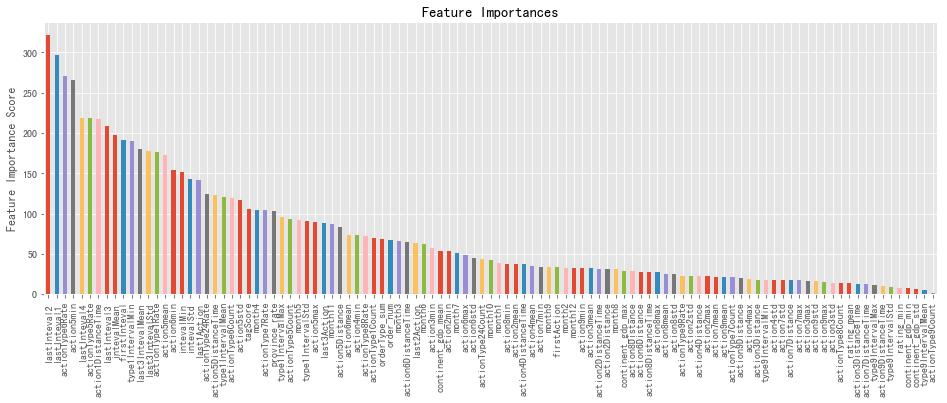

In [45]:
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5, # 树的最大深度
        min_child_weight=1, # 决定最小叶子节点样本权重和
        # 在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点，Gamma指定了节点分裂所需的最小损失函数下降值
        # 值越大，算法越保守
        gamma=0, 
        subsample=0.8, # 控制对于每颗树，随机采样的比例，0.8适合本题目
        colsample_bytree=0.8, # 控制每棵树随机采样的列数的占比
        objective= 'binary:logistic',
        # nthread=4, XGBoost运行时的线程数，缺省值是当前系统可以获得的最大线程数
        scale_pos_weight=1, # 在各类样本十分不平衡时，把这个参数设定为一个正值，可以使算法更快收敛
        seed=27 # 随机数的种子，设置它可以复现随机数据的结果，也可以用于调整参数
        )

train_data_sample = train_data.sample(frac=1.0)  # 全部打乱
cut_idx = int(round(0.2 * train_data.shape[0]))
train_test, train_train = train_data.iloc[:cut_idx], train_data.iloc[cut_idx:]
# print train_data.shape, train_test.shape, train_train.shape  # (40307, 126) (8061, 126) (32246, 126)

modelfit(xgb1, train_train, train_test, predictors, cv_folds=5)

In [38]:
# xgb1.fit(train_data[predictors], train_data[target], eval_metric='auc')
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
submit.to_csv(basedir + "submit_20180117.csv", index = False)

In [52]:
xgb2 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

train_data_sample = train_data.sample(frac=1.0)  # 全部打乱
cut_idx = int(round(0.3 * train_data_sample.shape[0]))
train_test, train_train = train_data_sample.iloc[:cut_idx], train_data_sample.iloc[cut_idx:]
# print train_data.shape, train_test.shape, train_train.shape  # (40307, 126) (8061, 126) (32246, 126)

# modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)
xgb2.fit(train_train[predictors], train_train['label'], eval_metric='auc')

dtest_predictions = xgb2.predict(train_test[predictors])
dtest_predprob = xgb2.predict_proba(train_test[predictors])[:,1]
        
#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(train_test['label'].values, dtest_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(train_test['label'], dtest_predprob)


Model Report
Accuracy : 0.9265
AUC Score (Train): 0.947347


In [51]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1.fit(train_data[predictors], train_data[target], eval_metric='auc')
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
print submit.to_csv(basedir + "submit_20180115.csv", index = False)

None


In [23]:
# param_test1 = {
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,6,2)
# }
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
# iid: 独立同分布
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=259, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc', n_jobs=1, iid=False, cv=5, verbose=5)
gsearch1.fit(train_data[predictors], train_data[target])

ValueError: 'auc' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [67]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.94846, std: 0.00156, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.94856, std: 0.00178, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.94859, std: 0.00193, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.95202, std: 0.00089, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.95186, std: 0.00080, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.95157, std: 0.00057, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.95137, std: 0.00039, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.95108, std: 0.00099, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.95175, std: 0.00100, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.95179, std: 0.00132, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.95170, std: 0.00140, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.95186, std: 0.00161, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [68]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=337, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5, verbose=5)
gsearch1.fit(train_data[predictors],train_data[target])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.0 .......................................................
[CV] .................. gamma=0.0, score=0.952277958108, total=  18.9s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s


[CV] .................. gamma=0.0, score=0.952220432923, total=  18.9s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.5s remaining:    0.0s


[CV] .................. gamma=0.0, score=0.954135817685, total=  19.0s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.9s remaining:    0.0s


[CV] .................. gamma=0.0, score=0.951876764666, total=  18.9s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] .................. gamma=0.0, score=0.950427889571, total=  19.0s
[CV] gamma=0.1 .......................................................
[CV] .................. gamma=0.1, score=0.951540829158, total=  18.4s
[CV] gamma=0.1 .......................................................
[CV] .................. gamma=0.1, score=0.951270231137, total=  18.8s
[CV] gamma=0.1 .......................................................
[CV] .................. gamma=0.1, score=0.953605465424, total=  18.8s
[CV] gamma=0.1 .......................................................
[CV] .................. gamma=0.1, score=0.952816463497, total=  19.0s
[CV] gamma=0.1 .......................................................
[CV] .................. gamma=0.1, score=0.950997176534, total=  18.9s
[CV] gamma=0.2 .......................................................
[CV] .................. gamma=0.2, score=0.951960813418, total=  19.0s
[CV] gamma=0.2 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  8.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=337, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [69]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.95219, std: 0.00118, params: {'gamma': 0.0},
  mean: 0.95205, std: 0.00100, params: {'gamma': 0.1},
  mean: 0.95201, std: 0.00086, params: {'gamma': 0.2},
  mean: 0.95190, std: 0.00092, params: {'gamma': 0.3},
  mean: 0.95259, std: 0.00100, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.95258621140145849)

67

Model Report
Accuracy : 0.9514
AUC Score (Train): 0.979964
lastInteval2           83
action5min             75
lastInteval1           72
actionType5rate        55
actionType6rate        54
lastInteval4           44
action1DistanceTime    42
intevalMean            39
intevalStd             37
intevalMin             36
lastInteval3           35
last1Action            34
last3IntevalStd        33
province_rate          33
action5mean            32
action5max             28
last3IntevalMean       28
actionType6Count       27
actionType1rate        27
action6min             27
actionType7rate        26
action5DistanceTime    26
action5std             23
actionType5Count       23
month11                22
actionType1Count       22
firstInteval           22
last3Action            20
actionType4rate        18
month4                 17
                       ..
actionType8Count        4
order_month7            3
action3std              3
age_nan                 3
action2max              3
a

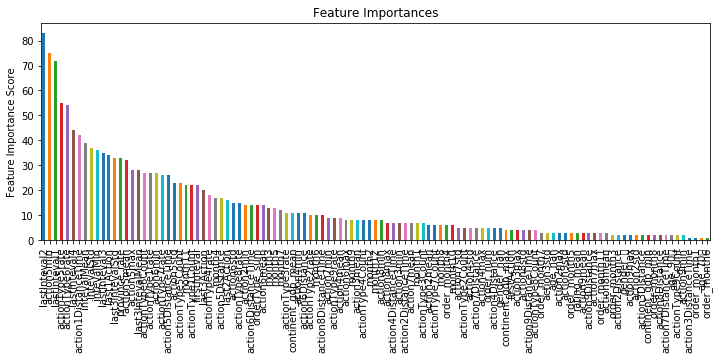

In [71]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.4,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)

170

Model Report
Accuracy : 0.9781
AUC Score (Train): 0.996446


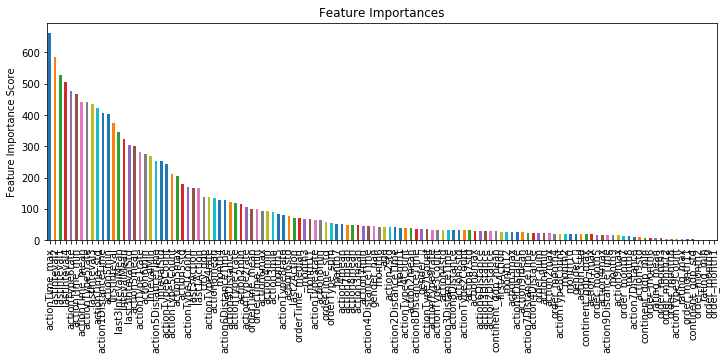

In [22]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.4,
        n_estimators=375,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)

In [48]:
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
print submit.to_csv(basedir + "submit_c.csv", index = False)

None
